In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

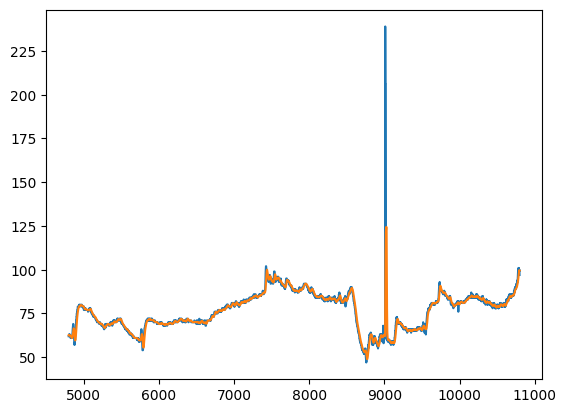

In [20]:
case = 6311
sampling_time = 2
df = pd.read_parquet(f'data/cases/case-{case:04d}.parquet')
df['signal'] = df['Solar8000/ART_MBP']#.interpolate()
# df.signal.bfill(inplace=True)
df['signal_smooth'] = df['signal'].rolling(20, min_periods=1).mean()



df['Time'] = df['Time'].astype('timedelta64[s]')
if sampling_time == 30:
    df = df.resample(f"{sampling_time}S", closed='right', label='right', on='Time').median()
    #extract the time from the index
    df['Time'] = df.index.total_seconds()
else:
    df = df.resample(f'{sampling_time}s', on='Time').last().reset_index()
    df['Time'] = df['Time'].dt.total_seconds()



Time_min = 60*60+20*60
Time_max = 60*60*3
df_plot = df[(df['Time'] > Time_min) & (df['Time'] < Time_max)]
plt.plot(df_plot['Time'], df_plot['signal'])

plt.plot(df_plot['Time'], df_plot['signal_smooth'])
plt.show()

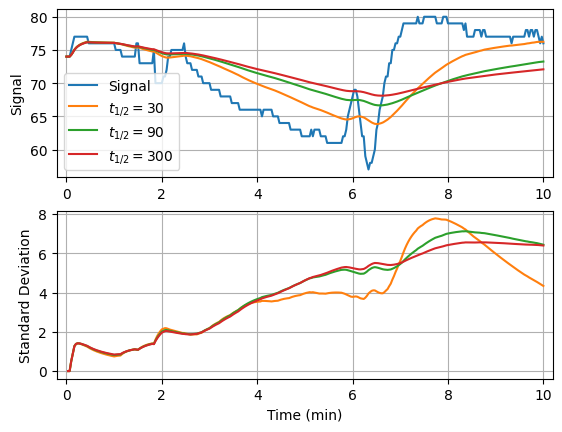

In [21]:


time_start = 1*60*60 + 15*60
time_end = time_start + 10*60

df = df[(df['Time'] >= time_start) & (df['Time'] <= time_end)]
df['Time'] -= time_start



half_times = [60, 3*60, 10*60]

# resample by keeping the last value


half_times = [int(half_time/sampling_time) for half_time in half_times]

df['exp_1'] = df['signal'].ewm(halflife=half_times[0]).mean()
df['exp_2'] = df['signal'].ewm(halflife=half_times[1]).mean()
df['exp_3'] = df['signal'].ewm(halflife=half_times[2]).mean()

df['exp_1_std'] = df['signal'].ewm(halflife=half_times[0]).std()
df['exp_2_std'] = df['signal'].ewm(halflife=half_times[1]).std()
df['exp_3_std'] = df['signal'].ewm(halflife=half_times[2]).std()

# df.to_csv('exponential_smoothing.csv', index=False)

plt.subplot(2, 1, 1)
plt.plot(df['Time']/60, df['signal'], label='Signal')
plt.plot(df['Time']/60, df['exp_1'], label=f'$t_{{1/2}}={half_times[0]}$')
plt.plot(df['Time']/60, df['exp_2'], label=f'$t_{{1/2}}={half_times[1]}$')
plt.plot(df['Time']/60, df['exp_3'], label=f'$t_{{1/2}}={half_times[2]}$')
plt.grid()
plt.legend()
plt.xlim(-0.2, 10.2)
plt.ylabel('Signal')
plt.subplot(2, 1, 2)
plt.xlim(-0.2, 10.2)
plt.plot(df['Time']/60, df['exp_1_std']*np.nan)
plt.plot(df['Time']/60, df['exp_1_std'], label=f'$t_{{1/2}}={half_times[0]}$')
plt.plot(df['Time']/60, df['exp_2_std'], label=f'$t_{{1/2}}={half_times[1]}$')
plt.plot(df['Time']/60, df['exp_3_std'], label=f'$t_{{1/2}}={half_times[2]}$')
plt.ylabel('Standard Deviation')
plt.xlabel('Time (min)')
plt.grid()
plt.show()

$t_{1/2}=30$
Coefficients: 0.017775305895439394
Intercept: 77.39885057471263
$t_{1/2}=90$
Coefficients: -0.023106556364983294
Intercept: 77.01198501872659
$t_{1/2}=300$
Coefficients: 0.011216280180890902
Intercept: 73.44305016722407


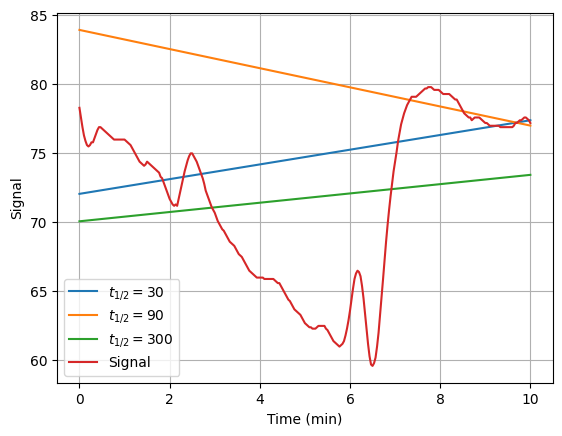

In [22]:
# Linear regression
# on the last 10 seconds



for half_time in half_times:
    model = LinearRegression()
    x = np.arange(-half_time, 0,).reshape(-1, 1)
    model.fit(x, df.signal_smooth.iloc[-half_time:].values)
    y_pred = model.predict((df.Time.values.reshape(-1, 1)-df.Time.values[-1])/2)
    plt.plot(df.Time.values/60, y_pred, label=f'$t_{{1/2}}={half_time}$')
    df[f'signal_reg_{half_time}'] = y_pred
    feature = model.predict([[1]])
    print(f'$t_{{1/2}}={half_time}$')
    print(f'Coefficients: {model.coef_[0]}')
    print(f'Intercept: {model.intercept_}')
plt.plot(df['Time']/60, df['signal_smooth'], label='Signal')
plt.grid()
plt.legend()
plt.xlabel('Time (min)')
plt.ylabel('Signal')
plt.show()
df.to_csv('linear_reg.csv', index=False)